# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os

# Set style for plots
plt.style.use('seaborn-v0_8')
%matplotlib inline

## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [ ]:
def load_wes_csv(path: str, name: str):
    df = pd.read_csv(path, header=None, names=[name])
    init, freq = df[name].loc[:1].to_list()
    df = df[2:]
    df['timestamp'] = init + df.index * freq
    return df

def load_data(data_dir='data/raw'):
    """Load and organize the physiological data from the dataset.
    
    Parameters
    ----------
    data_dir : str
        Path to the directory containing the dataset files
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the organized physiological data with columns:
        ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    """
    all_records = []
    for subject_id in os.listdir(data_dir):
        for session in os.listdir(os.path.join(data_dir, subject_id)):
            dir = os.path.join(data_dir, subject_id, session)
            hr_df = load_wes_csv(os.path.join(dir, 'HR.csv'), 'heart_rate')
            eda_df = load_wes_csv(os.path.join(dir, 'EDA.csv'), 'eda')
            temp_df = load_wes_csv(os.path.join(dir,  'TEMP.csv'), 'temperature')
            
            merged = eda_df
            merged = merged.merge(hr_df, left_index=True, right_index=True, how='left')
            merged = merged.merge(temp_df, left_index=True, right_index=True, how='left')


            merged['timestamp'] = pd.to_datetime(merged['timestamp'], unit='s')
            merged['subject_id'] = subject_id
            merged['session'] = session

            all_records.append(merged)
    
    final_df = pd.concat(all_records, ignore_index=True)
    return final_df[['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']]

data = load_data("physionet.org/files/wearable-exam-stress/1.0.0/data")
data

,timestamp,heart_rate,eda,temperature,subject_id,session
0,2018-12-05 16:29:15,123.00,0.000000,22.59,S6,Final
1,2018-12-05 16:29:19,116.00,0.002562,22.59,S6,Final
2,2018-12-05 16:29:23,98.67,0.017935,22.59,S6,Final
3,2018-12-05 16:29:27,95.25,0.017935,22.59,S6,Final
4,2018-12-05 16:29:31,90.20,0.017935,22.59,S6,Final
...,...,...,...,...,...,...
1773115,2018-10-15 16:51:37,NaN,0.020501,24.41,S10,midterm_1
1773116,2018-10-15 16:51:41,NaN,0.020501,24.41,S10,midterm_1
1773117,2018-10-15 16:51:45,NaN,0.020501,24.41,S10,midterm_1
1773118,NaT,NaN,0.020501,NaN,S10,midterm_1


## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [ ]:
def preprocess_data(data, output_dir='data/processed'):
    """Clean and prepare the physiological data for analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw physiological data
    output_dir : str
        Directory to save processed data files
        
    Returns
    -------
    pd.DataFrame
        Cleaned and preprocessed data
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    missing_rate = data.isna().mean()
    if missing_rate.max() > 0.01:
        print("Info: Some columns have >1% missing values. Dropping rows with NaN.")
        
        dfs = []
        for subject_id in data['subject_id'].unique():
            for session in data[data['subject_id'] == subject_id]['session'].unique():
                df = data[data['subject_id'] == subject_id]
                df = df[df['session'] == session]
                df = df.drop(['subject_id', 'session'], axis=1)
                df = df.dropna()
                df = df.resample('5s', on='timestamp').mean()
                df = df.reset_index()
                df['subject_id'] = subject_id
                df['session'] = session

                z = np.abs(stats.zscore(df[['heart_rate', 'eda', 'temperature']]))
                df = df[(z < 3.5).all(axis=1)]
                dfs.append(df)
        data = pd.concat(dfs).reset_index()

    for subject_id in data['subject_id'].unique():
        df = data[data['subject_id'] == subject_id]
        df.to_csv(os.path.join(output_dir, subject_id + '_processed.csv'))

    return data

data = preprocess_data(data)
data

Info: Some columns have >1% missing values. Dropping rows with NaN.


,index,timestamp,heart_rate,eda,temperature,subject_id,session
0,0,2018-12-05 16:29:15,119.500,0.001281,22.59,S6,Final
1,1,2018-12-05 16:29:20,98.670,0.017935,22.59,S6,Final
2,2,2018-12-05 16:29:25,95.250,0.017935,22.59,S6,Final
3,3,2018-12-05 16:29:30,90.200,0.017935,22.59,S6,Final
4,4,2018-12-05 16:29:35,94.235,0.019217,22.59,S6,Final
...,...,...,...,...,...,...,...
351534,9338,2018-10-14 01:53:40,118.800,0.021783,22.61,S10,midterm_1
351535,9339,2018-10-14 01:53:45,118.650,0.019220,22.61,S10,midterm_1
351536,9340,2018-10-14 01:53:50,118.550,0.017939,22.61,S10,midterm_1
351537,9341,2018-10-14 01:53:55,118.470,0.019220,22.61,S10,midterm_1


## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

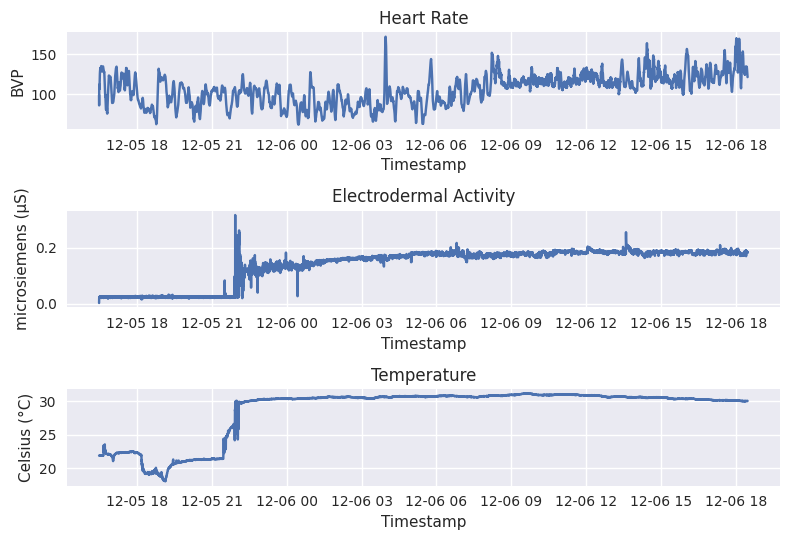

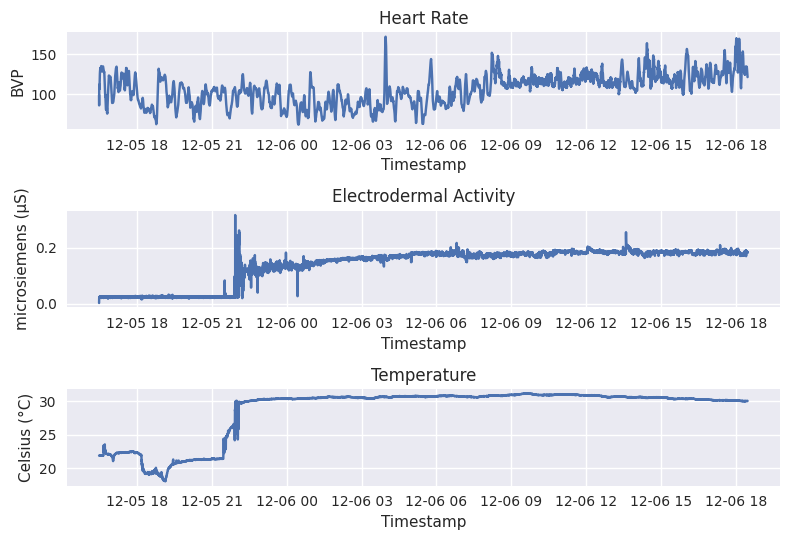

In [50]:
def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    """Create plots of physiological signals for a given subject and session.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    subject_id : str
        Subject identifier (e.g., 'S1')
    session : str
        Session identifier (e.g., 'Midterm 1')
    output_dir : str
        Directory to save plot files
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Your code here
    # 1. Create figure with subplots
    # 2. Plot each physiological signal
    # 3. Add labels and titles
    # 4. Save plot to file
    df = data[data['subject_id'] == subject_id]
    df = df[df['session'] == session]
    df = df.sort_values('timestamp')

    fig, axs = plt.subplots(3, 1)
    axs[0].plot(df['timestamp'], df['heart_rate'])
    axs[0].set_title('Heart Rate')
    axs[0].set_xlabel('Timestamp')
    axs[0].set_ylabel('BVP')
    axs[1].plot(df['timestamp'], df['eda'])
    axs[1].set_title('Electrodermal Activity')
    axs[1].set_xlabel('Timestamp')
    axs[1].set_ylabel('microsiemens (μS)')
    axs[2].plot(df['timestamp'], df['temperature'])
    axs[2].set_title('Temperature')
    axs[2].set_xlabel('Timestamp')
    axs[2].set_ylabel('Celsius (°C)')
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, f"{subject_id}_{session}_signals.png"))

    return fig
    
plot_physiological_signals(data, 'S1', 'Final')